<a href="https://colab.research.google.com/github/ilman79/Machine-Learning/blob/main/Development_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Akses untuk melihat sumber data dari website kaggle : [dataset](https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification?resource=download)

In [ ]:
#import data set


In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-171-g6e04b94 Python-3.10.11 torch-2.0.1+cu118 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.3/107.7 GB disk)


In [3]:
!pip install roboflow

%cd ../datasets/

from roboflow import Roboflow
rf = Roboflow(api_key="lpNWV82uE9gZMd1p5IsI")
project = rf.workspace("ilman-gifari-utdmy").project("rrd3")
dataset = project.version(1).download("yolov5")



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[Errno 2] No such file or directory: '../datasets/'
/content/yolov5
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to RRD3-1 in yolov5pytorch:: 100%|██████████| 384/384 [00:00<00:00, 884.64it/s]


In [4]:
%cd ../yolov5
from utils.downloads import attempt_download

p5 = ['n', 's', 'm', 'l', 'x']  # P5 models
cls = [f'{x}-cls' for x in p5]  # classification models

for x in cls:
    attempt_download(f'weights/yolov5{x}.pt')

/content/yolov5


100%|██████████| 4.87M/4.87M [00:00<00:00, 13.5MB/s]

100%|██████████| 10.5M/10.5M [00:00<00:00, 40.3MB/s]

100%|██████████| 24.9M/24.9M [00:00<00:00, 61.3MB/s]

100%|██████████| 50.9M/50.9M [00:01<00:00, 51.8MB/s]

100%|██████████| 92.0M/92.0M [00:02<00:00, 44.6MB/s]



In [21]:
!python train.py --img 430  --batch 16 --epochs 10 --data /content/yolov5/RRD3-1/data.yaml --weights yolov5s.pt --cache


train: weights=yolov5s.pt, cfg=, data=/content/yolov5/RRD3-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=430, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-171-g6e04b94 Python-3.10.11 torch-2.0.1+cu118 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degr

In [24]:
# Uji model
!python detect.py --weight /content/yolov5/runs/train/exp4/weights/best.pt --img 320 --conf 0.1 --source /content/yolov5/RRD3-1/test/images

detect: weights=['/content/yolov5/runs/train/exp4/weights/best.pt'], source=/content/yolov5/RRD3-1/test/images, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-171-g6e04b94 Python-3.10.11 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7080247 parameters, 0 gradients, 16.0 GFLOPs
image 1/9 /content/yolov5/RRD3-1/test/images/lampu-merah-93-_jpg.rf.841ec37f9776fba39edc6454079c2b76.jpg: 320x320 (no detections), 117.3ms
image 2/9 /content/yolov5/RRD3-1/test/images/larangan-belok-kanan-71-_jpg.rf.7e99ae14a8fc56f41e7a67aa3387406d.jpg: 320x320 (no detections), 110.2ms
image 3/9 /content/yolov5/RRD3-1/test/images/laranga

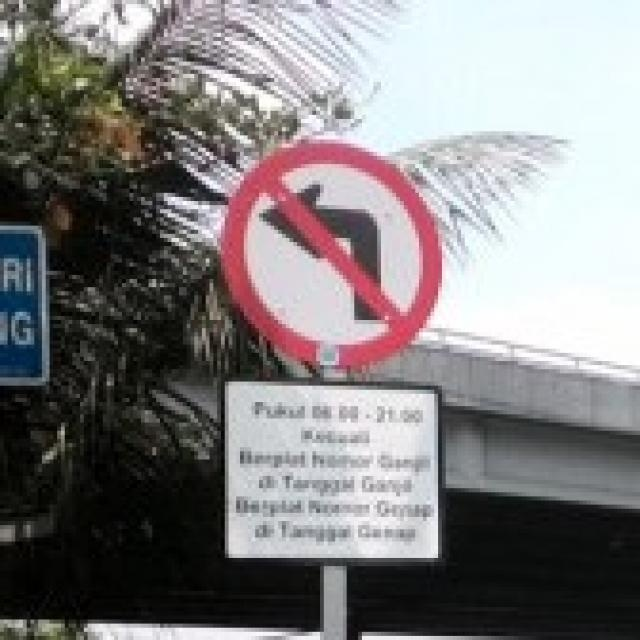

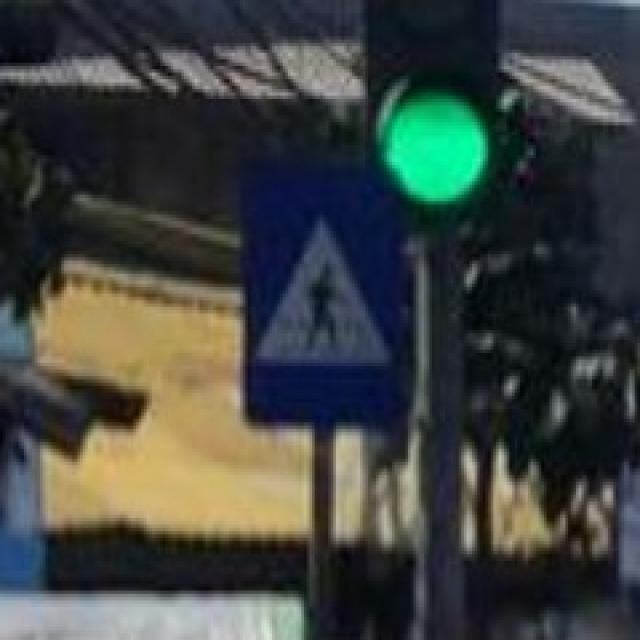

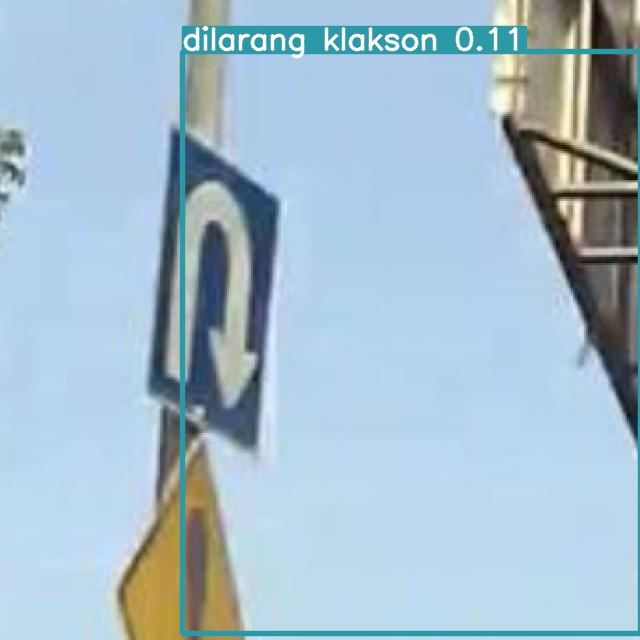

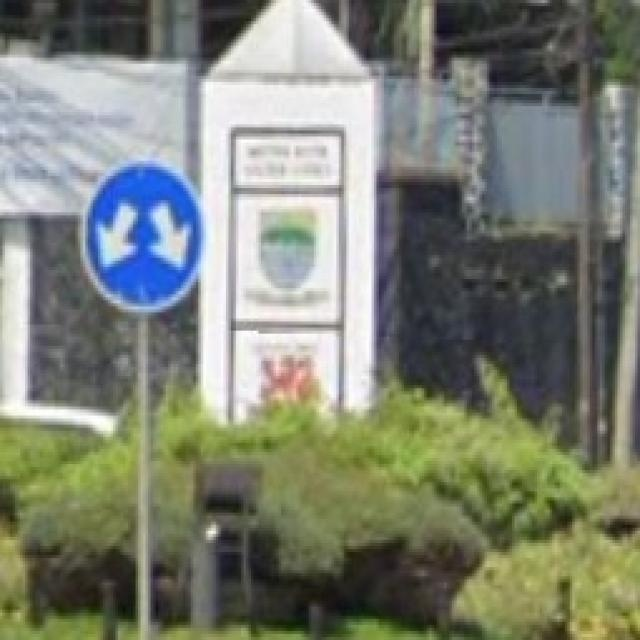

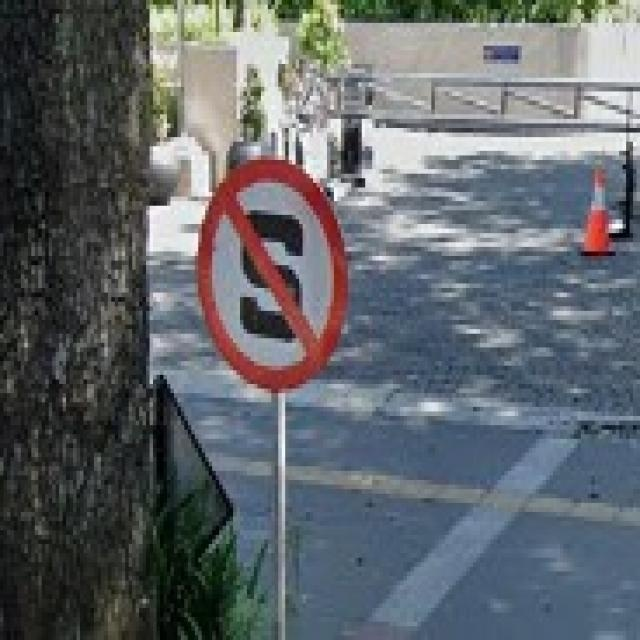

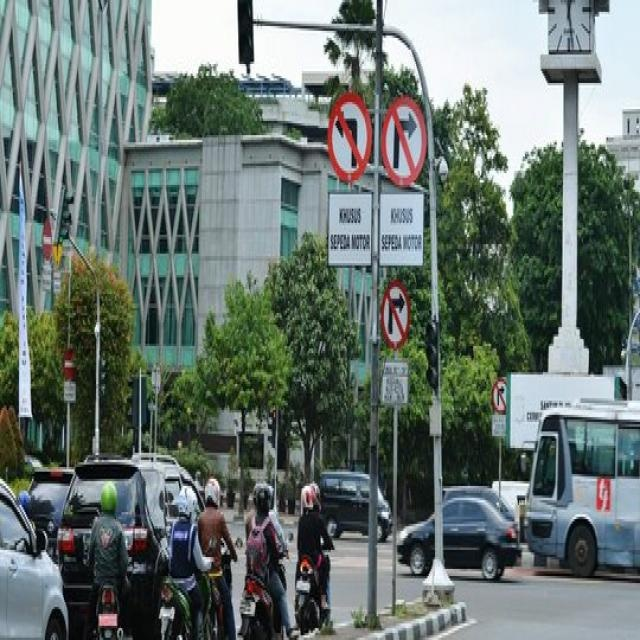

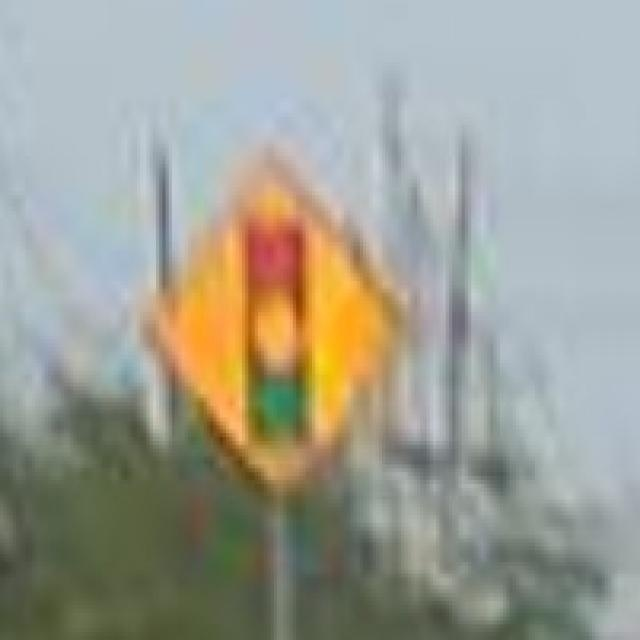

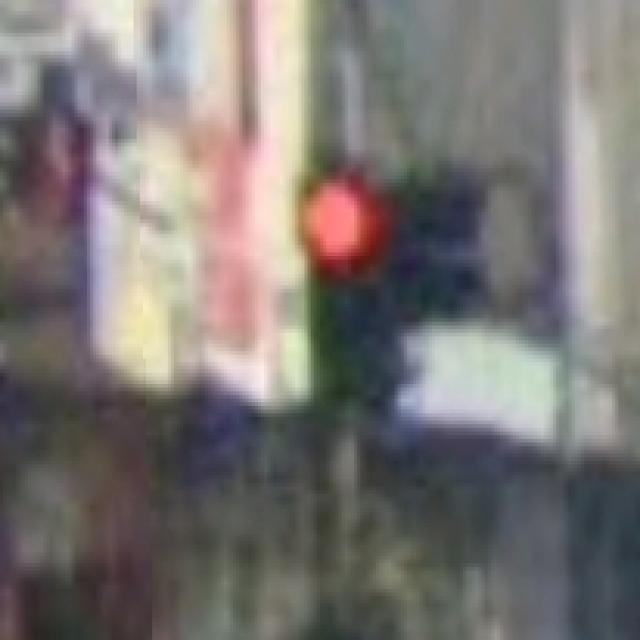

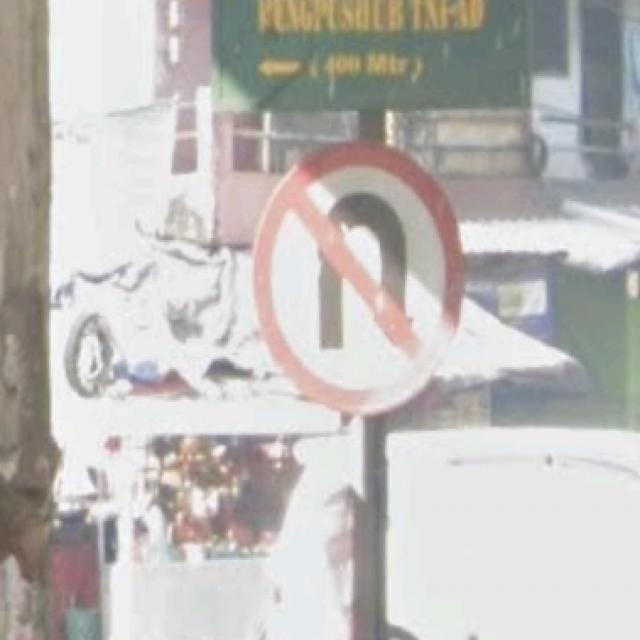

In [25]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp5/*.jpg'):
  display(Image(filename=imageName))


#Testing menggunakan yoloV5

In [ ]:
!git clone https://github.com/hukaixuan19970627/yolov5_obb.git


Cloning into 'yolov5_obb'...
remote: Enumerating objects: 704, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 704 (delta 153), reused 85 (delta 85), pack-reused 506
Receiving objects: 100% (704/704), 18.16 MiB | 22.19 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [ ]:
%cd /content/yolov5_obb/
!pip install -r requirements.txt

[Errno 2] No such file or directory: '/content/yolov5_obb/'
/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd utils/nms_rotated
!python setup.py develop  #or "pip install -v -e ."

[Errno 2] No such file or directory: 'utils/nms_rotated'
/content/yolov5
python3: can't open file '/content/yolov5/setup.py': [Errno 2] No such file or directory
